# PHYS 441/DATA SCI 421 FINAL

## Analysis of the M-$\sigma$ relationship

---

Caleb Wang 

08 December 2023

## Introduction

In astrophysics, the [M-$\sigma$](https://en.wikipedia.org/wiki/M–sigma_relation) relationship relates the mass of the [supermassive blackhole](https://en.wikipedia.org/wiki/Supermassive_black_hole) located at the center of a galaxy (denoted by M) and the [velocity dispersion](https://en.wikipedia.org/wiki/Velocity_dispersion) of stars in the bulge or central region of that galaxy (denoted by sigma). The relationship is important for understanding a number of astrophysical phenomenons, such as galaxy evolutions, black hole formations, and gravitational waves. 

In this project, we try to investigate this relation by employing linear regression techniques on emperically collected data of blackhole masses ($M_{BH}$) and its dispersion velocity ($\sigma$). By conducting an analytical analysis of the M-$\sigma$ relationship, we gain further understanding of the evolutions of blackholes and galaxies. 

## Data

The data provided is from a paper _The M-σ and M-L Relations in Galactic Bulges and Determinations of Their Intrinsic Scatter_, which goal is to understand the supermassive blackhole masses and host-galaxy bulge velocity dispersion. The authors complied a sample of black hole measurements published before 2008, manually included and excluded data, and corrected for errors in previously collected data. 

In [156]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

df = pd.read_csv('M-sigma.csv') 

### Step 0: Understanding the data
We start our analysis by trying to visualize the data. Fig 1. shows the original data with errors on both the x and y axis. The data shows some degree of positive correlation, albeit not linear. The concentration of data points in the lower left part of the graph and sparsity of data points in the upper right suggest that the relationship may be logrithmic. Fig 2 shows that the relation between the log of blackhole masses and dispersion velocity, which seems to be linear. 


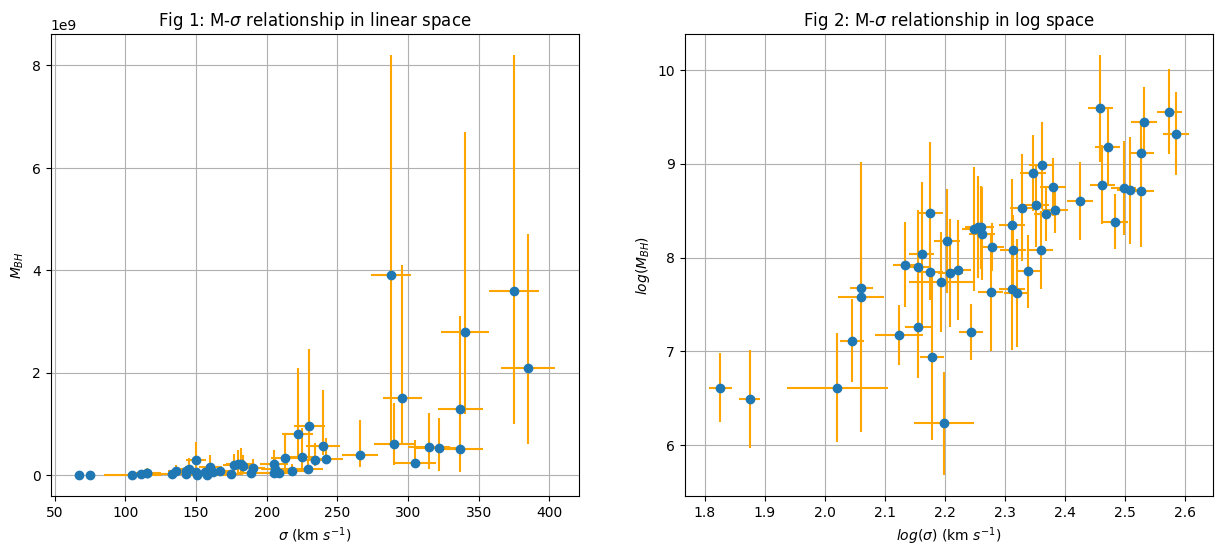

In [285]:
# data in linear scale
sigma = df['sigma']
sigma_unc = df['sigma_unc']

M_BH = df['M_BH']
M_BH_unc_high = df['M_BH_unc+']
M_BH_unc_low  = df['M_BH_unc-']

# data in log scale 
log_sigma = np.log10(df['sigma'])
log_M_BH = np.log10(df['M_BH'])

log_sigma_upper = np.log10(df['sigma'] + df['sigma_unc'])
log_sigma_lower = np.log10(df['sigma'] - df['sigma_unc'])
log_M_BH_upper = np.log10(df['M_BH'] + df['M_BH_unc+'])
log_M_BH_lower = np.log10(df['M_BH'] - df['M_BH_unc-']) 

# assuming symmetric uncertainty 
log_sigma_unc = 0.5*(log_sigma_upper - log_sigma_lower)
log_M_BH_unc = 0.5*(log_M_BH_upper - log_M_BH_lower)

fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 

# Plotting in linear space 
ax[0].errorbar(
    sigma, 
    M_BH, 
    xerr=sigma_unc, 
    yerr=[M_BH_unc_low, M_BH_unc_high], 
    fmt='o',
    ecolor='orange', 
    )
ax[0].set_title('Fig 1: M-$\sigma$ relationship in linear space')
ax[0].set_xlabel('$\sigma$ (km $s^{-1})$')
ax[0].set_ylabel('$M_{BH}$')
ax[0].grid(True)

# Plotting in log space 
ax[1].errorbar(
    log_sigma, 
    log_M_BH, 
    xerr=log_sigma_unc, 
    yerr=log_M_BH_unc, 
    fmt='o',
    ecolor='orange', 
    )
ax[1].set_title('Fig 2: M-$\sigma$ relationship in log space')
ax[1].set_xlabel('$log(\sigma)$ (km $s^{-1})$')
ax[1].set_ylabel('$log(M_{BH})$')
ax[1].grid(True)

## Analysis


In the reference paper provided, the relationship between $M_{BH}$ and $\sigma$ is given by

\begin{align}
log(M_{BH}) = \alpha log(\sigma) + \beta
\end{align}

which is indeed a linear relationship. 




### Step 1: Fitting a line (linear regression) without x-axis uncertainty 

#### Using `LinearRegression` from `sklearn`
As a first step, we try to fit a line to the data in log-scale, just to get a rough idea of the range $\alpha$ and $\beta$ may fall into. Fig 3. shows the fitted line with $\alpha \approx 3.912$ and $\beta \approx -0.82$. These values will serve as the basis for further analysis, albeit obtained not accounting for x-axis uncertainty and outliers. Hence they should only be used as a rough estimate. 

3.9123716606183008 -0.81989379124464


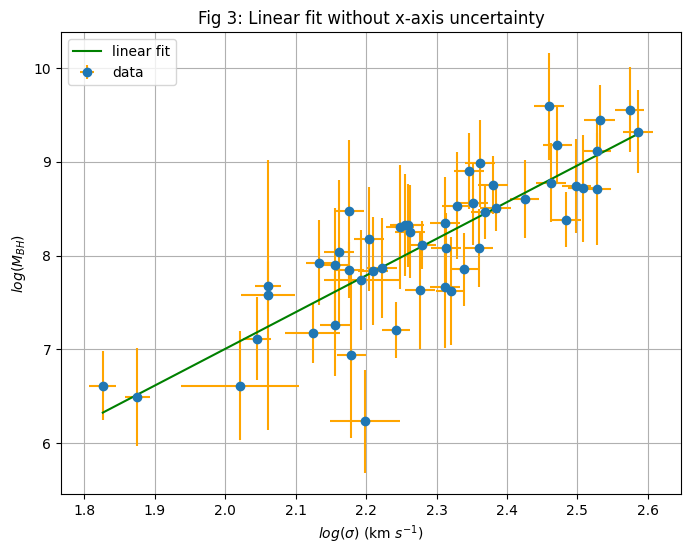

In [286]:
from sklearn.linear_model import LinearRegression 

x_arr = np.array(log_sigma).reshape((-1, 1)) 
y_arr = log_M_BH 

model = LinearRegression().fit(x_arr, y_arr) 
alpha, beta = model.coef_[0], model.intercept_ 
print(alpha, beta)

x_axis = np.linspace(min(log_sigma), max(log_sigma), 1000) 
y_axis = alpha*x_axis + beta 

fig, ax = plt.subplots(figsize=(8, 6)) 

ax.errorbar(
    log_sigma, 
    log_M_BH, 
    xerr=log_sigma_unc, 
    yerr=log_M_BH_unc, 
    fmt='o',
    ecolor='orange', 
    label='data'
    )
ax.set_title('Fig 3: Linear fit without x-axis uncertainty')
ax.set_xlabel('$log(\sigma)$ (km $s^{-1})$')
ax.set_ylabel('$log(M_{BH})$')
ax.grid(True)

ax.plot(x_axis, y_axis, color='green', label='linear fit')
ax.legend(loc='upper left')

### Step 2: Fitting a line accounting for x-axis uncertainty 

#### Using `scipy.odr`
Now we account for uncertainties in both the dependent axis (y-axis) and independent axis (x-axis). This is a problem in statistics literature known as _total least squares_. 

Fortunately, `scipy` has a built-in function for solving the total least squares problem. The `scipy.odr` function, standing for _Orthogonal Distance Regression_, minimizes the orthogonal distance between data points to the regression line. Fig. 4 shows the fitted line along with the 68\% confidence intervals. The slope $\alpha \approx 3.85$ and intercept $\beta \approx -0.691$, which are both lower quite a bit lower than in Step 1. 

[ 3.85842038 -0.69153168]


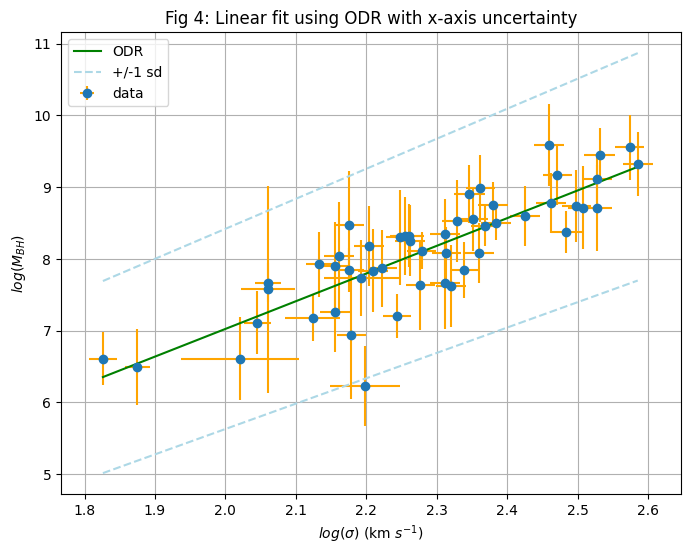

In [261]:
from scipy.odr import *

def func(theta, x):
    alpha, beta = theta
    return alpha*x + beta 

model = Model(func)
data = RealData(log_sigma, log_M_BH, sx=log_sigma_unc, sy=log_M_BH_unc)
odr = ODR(data, model, beta0 = [4, 0])
output = odr.run()

def get_x_y_axis(theta):
    alpha, beta = theta
    x_axis = np.linspace(min(log_sigma), max(log_sigma), 1000)
    # y_axis = alpha*np.log10(x_axis) + beta
    y_axis = alpha*x_axis + beta

    return x_axis, y_axis 


theta = output.beta 
print(theta)
theta_one_std_higher = output.beta + output.sd_beta
theta_one_std_lower = output.beta - output.sd_beta

x_original, y_original = get_x_y_axis(theta)
x_1_std_plus, y_1_std_plus = get_x_y_axis(theta_one_std_higher)
x_1_std_minus, y_1_std_minus = get_x_y_axis(theta_one_std_lower)

fig, ax = plt.subplots(figsize=(8, 6), sharey=True)
ax.errorbar(
    log_sigma, 
    log_M_BH, 
    xerr=log_sigma_unc, 
    yerr=log_M_BH_unc, 
    fmt='o',
    ecolor='orange', 
    label='data'
    )

ax.plot(x_axis, y_axis, color='green', label='ODR') 
plt.plot(x_1_std_plus, y_1_std_plus, '--', color='lightblue', label='+/-1 sd')
plt.plot(x_1_std_minus, y_1_std_minus, '--', color='lightblue')

ax.set_title('Fig 4: Linear fit using ODR with x-axis uncertainty')
ax.set_xlabel('$log(\sigma)$ (km $s^{-1})$')
ax.set_ylabel('$log(M_{BH})$')
ax.grid(True)

ax.legend(loc='upper left')

#### 2.1 Frequentist: Using MLE and `scipy.optimize.minimize` 

Next we try and fit a line using Maximum Likelihood Estimation. We obtain a slope of 3.85 and intercept of -0.691, which is the same as using ODR in the previous section. 

3.8584484439731765 -0.6915962268728606


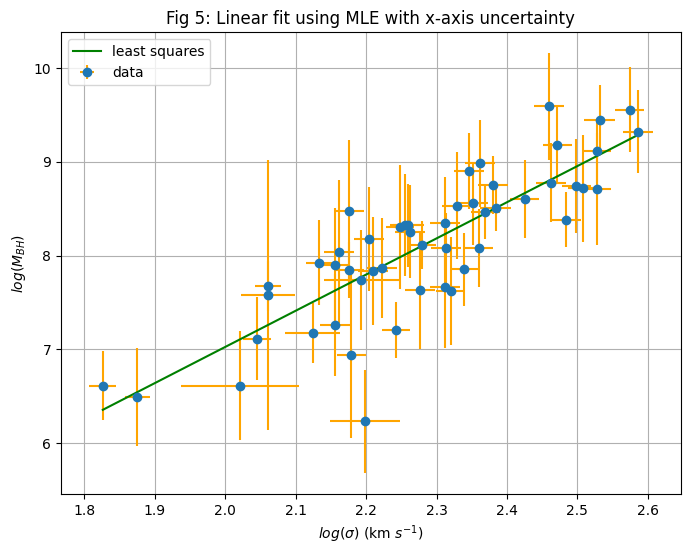

In [253]:
from scipy.optimize import minimize 

def model(theta, x):
    alpha, beta = theta
    return alpha*x + beta 

def nll(theta, y_obs, y_obs_unc, x_obs, x_obs_unc): 
    theta1, theta0 = theta 
    alpha = np.arctan(theta1)
    
    lnl = 0 
    for i in range(len(y_obs)):
        sigma_i = np.array([[x_obs_unc[i]**2, 0], 
                            [0, y_obs_unc[i]**2]]) 
        n = np.array([[-np.sin(alpha)], 
                      [np.cos(alpha)]
                      ])
        sigma_i_squared = (n.T @ sigma_i @ n)
        sigma_i_squared = sigma_i_squared[0][0]

        z_i = np.array([
            [x_obs[i]], 
            [y_obs[i]]
            ])        
        
        delta_i = (n.T @ z_i)[0][0] - theta0*np.cos(alpha)

        lnl += (delta_i**2) / (2*sigma_i_squared)
    return lnl


init_guess = (4, 0)
alpha, beta = minimize(nll, init_guess, args=(log_M_BH, log_M_BH_unc, log_sigma, log_sigma_unc)).x
print(alpha, beta) 

x_axis = np.linspace(min(log_sigma), max(log_sigma), 1000)   
y_axis = alpha*x_axis + beta 

fig, ax = plt.subplots(figsize=(8, 6), sharey=True)
ax.errorbar(
    log_sigma, 
    log_M_BH, 
    xerr=log_sigma_unc, 
    yerr=log_M_BH_unc, 
    fmt='o',
    ecolor='orange', 
    label='data'
    )

ax.plot(x_axis, y_axis, color='green', label='MLE') 

ax.set_title('Fig 5: Linear fit using MLE with x-axis uncertainty')
ax.set_xlabel('$log(\sigma)$ (km $s^{-1})$')
ax.set_ylabel('$log(M_{BH})$')
ax.grid(True)

ax.legend(loc='upper left')

#### 2.2 Bayesian: Using MCMC

We then try fitting a line to the data using a bayesian approach. We select uninformative flat distributions as priors since the choice of priors doesn't affect the result much. We obtain a slope ($\alpha$) of 3.848 and intercept ($\beta$) of -0.670. This value is a different than what was obtained previously.  

[ 3.84866038 -0.67032467]


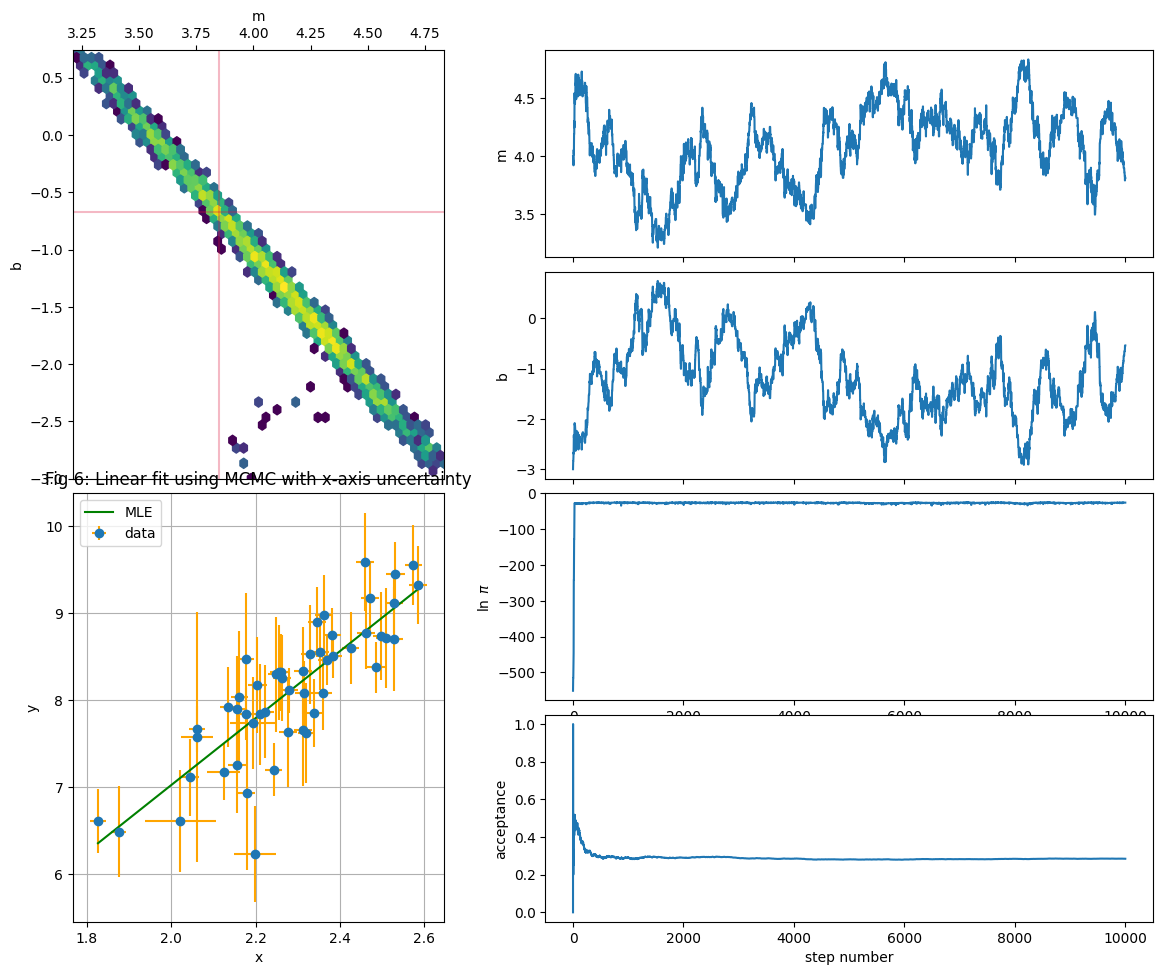

In [282]:
def _lnlikelihood(theta, y, x, y_unc, x_unc):
    m, b = theta 
    model_preds = m*x + b 
    total_unc = np.sqrt(y_unc**2 + x_unc**2)
    lnl = -1 * np.sum( (y - model_preds)**2/(2*(total_unc**2)) ) # compute the log likelihood  
    return lnl 

def lnlikelihood(theta, y_obs, x_obs, y_obs_unc, x_obs_unc): 
    theta1, theta0 = theta 
    alpha = np.arctan(theta1)
    
    lnl = 0 
    for i in range(len(y_obs)):
        sigma_i = np.array([[x_obs_unc[i]**2, 0], 
                            [0, y_obs_unc[i]**2]]) 
        n = np.array([[-np.sin(alpha)], 
                      [np.cos(alpha)]
                      ])
        sigma_i_squared = (n.T @ sigma_i @ n)
        sigma_i_squared = sigma_i_squared[0][0]

        z_i = np.array([
            [x_obs[i]], 
            [y_obs[i]]
            ])        
        
        delta_i = (n.T @ z_i)[0][0] - theta0*np.cos(alpha)

        lnl += -1*(delta_i**2) / (2*sigma_i_squared)
    return lnl

def lnprior(theta):
  alpha, beta = theta
  if -10.0 < alpha < 10.0 and -10.0 < beta < 10.0: 
      return np.log(1/20) + np.log(1/20)
  return -np.inf

def lnposterior(theta, y, x, y_unc, x_unc): 
    lnp = lnprior(theta) # compute the log prior  
    if not np.isfinite(lnp): return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc, x_unc) # the log likelihood function 
    
    return lnl + lnp # return the log posterior 

def hastings_ratio(theta_1, theta_0, y, x, y_unc, x_unc):
    lnpost1 = lnposterior(theta_1, y, x, y_unc, x_unc) # complete
    lnpost0 = lnposterior(theta_0, y, x, y_unc, x_unc) # complete
    
    h_ratio = np.exp(lnpost1)/np.exp(lnpost0) # complete
    
    return h_ratio

def propose_jump(theta, cov):
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov) # complete
    
    return proposed_position

def mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc, x_unc):
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0

    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y_obs, x, y_unc, x_unc)

    for step_num in range(1,nsteps+1):
        new_pos = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(new_pos, positions[step_num-1], y_obs, x, y_unc, x_unc)
        if H >= 1:
            positions[step_num] = new_pos
            lnpost_at_pos[step_num] = lnposterior(new_pos, y_obs, x, y_unc, x_unc)
            accepted += 1
            acceptance_ratio[step_num] = accepted/step_num
        else:
            r = np.random.rand()
            if r <= H: 
                positions[step_num] = new_pos
                lnpost_at_pos[step_num] = lnposterior(new_pos, y_obs, x, y_unc, x_unc)
                accepted += 1
                acceptance_ratio[step_num] = accepted/step_num
            else:
                positions[step_num] = positions[step_num-1]
                lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
                acceptance_ratio[step_num] = accepted/step_num
    
    return (positions, lnpost_at_pos, acceptance_ratio)

def plot_mh_summary(theta_0, cov, nsteps, y_obs, x, y_unc, x_unc):
    pos, lnpost, acc = mh_mcmc(theta_0, cov, nsteps, y_obs, x, y_unc, x_unc)

    fig = plt.figure(figsize=(12,10))
    ax1 = plt.subplot2grid((4,5), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((4,5), (2, 0), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((4,5), (0, 2), colspan=3)
    ax4 = plt.subplot2grid((4,5), (1, 2), colspan=3, sharex=ax3)
    ax5 = plt.subplot2grid((4,5), (2, 2), colspan=3, sharex=ax3)
    ax6 = plt.subplot2grid((4,5), (3, 2), colspan=3, sharex=ax3)

    top_10 = sorted(zip(pos, lnpost), key=lambda x: x[1], reverse=True)[0]
    top_pos, _ = top_10
    print(top_pos)

    ax1.hexbin(pos[:,0], pos[:,1], gridsize=50, mincnt=1, bins='log')
    all_m, all_b = pos[:,0], pos[:,1]
    ylims = (min(all_b), max(all_b)) 
    xlims = (min(all_m), max(all_m)) 
    ax1.plot([top_pos[0], top_pos[0]], ylims, 'Crimson', alpha=0.3)
    ax1.plot(xlims, [top_pos[1], top_pos[1]], 'Crimson', alpha=0.3)
    ax1.set_ylim(ylims)
    ax1.set_xlim(xlims)
    ax1.set_xlabel('m')
    ax1.set_ylabel('b')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.tick_params(top=True, bottom=False)

    # ax2.errorbar(x, y_obs, yerr=y_unc, xerr=x_unc, fmt='o')

    ax2.errorbar(
    log_sigma, 
    log_M_BH, 
    xerr=log_sigma_unc, 
    yerr=log_M_BH_unc, 
    fmt='o',
    ecolor='orange', 
    label='data'
    )   
    
    x_axis = np.linspace(min(x), max(x), 1000) 
    y_axis = top_pos[0]*x_axis + top_pos[1] 
    ax2.plot(x_axis, y_axis, color='green', label='MLE') 

    ax2.set_title('Fig 6: Linear fit using MCMC with x-axis uncertainty')
    ax2.set_xlabel('$log(\sigma)$ (km $s^{-1})$')
    ax2.set_ylabel('$log(M_{BH})$')
    ax2.grid(True)

    ax2.legend(loc='upper left')

    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.plot(pos[:,0])
    ax3.set_ylabel('m')
    
    ax4.plot(pos[:,1])
    ax4.set_ylabel('b')

    ax5.plot(lnpost)
    ax5.set_ylabel('$\ln \; \pi$')

    ax6.plot(acc)
    ax6.set_ylabel('acceptance')
    ax6.set_xlabel('step number')
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, left=0.09, right=0.99, hspace=0.07, wspace=0.75)

    return pos, lnpost, acc 

starting_m_b = (4, -3) 
cov = (0.1, 0.1)  
pos, lnpost, acc  = plot_mh_summary(starting_m_b, cov, 10000, log_M_BH, log_sigma, log_M_BH_unc, log_sigma_unc)

#### 2.3 Bayesian: Using `emcee` 

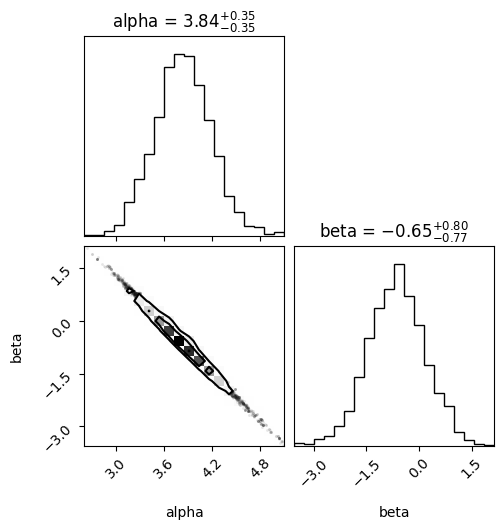

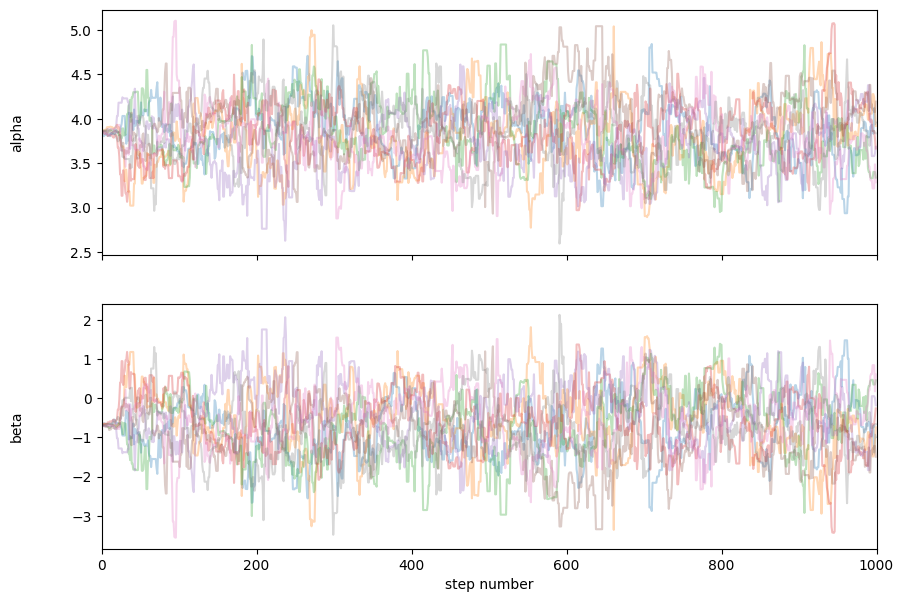

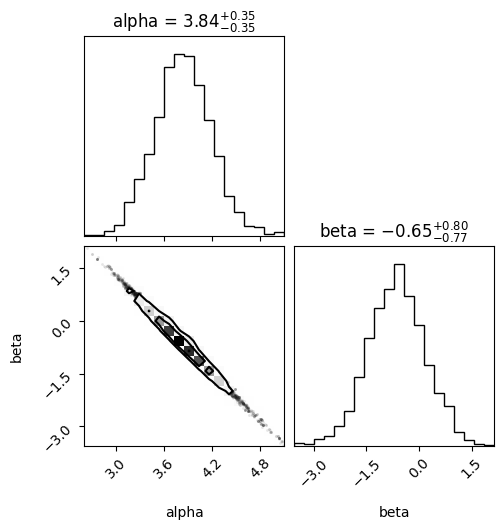

In [275]:
import emcee 
import corner 

def lnlikelihood(theta, y_obs, x_obs, y_obs_unc, x_obs_unc): 
    theta1, theta0 = theta 
    alpha = np.arctan(theta1)
    
    lnl = 0 
    for i in range(len(y_obs)):
        sigma_i = np.array([[x_obs_unc[i]**2, 0], 
                            [0, y_obs_unc[i]**2]]) 
        n = np.array([[-np.sin(alpha)], 
                      [np.cos(alpha)]
                      ])
        sigma_i_squared = (n.T @ sigma_i @ n)
        sigma_i_squared = sigma_i_squared[0][0]

        z_i = np.array([
            [x_obs[i]], 
            [y_obs[i]]
            ])        
        
        delta_i = (n.T @ z_i)[0][0] - theta0*np.cos(alpha)

        lnl += -1*(delta_i**2) / (2*sigma_i_squared)
    return lnl

def lnprior(theta):
  alpha, beta = theta
  if -10.0 < alpha < 10.0 and -10.0 < beta < 10.0: 
      return np.log(1/20) + np.log(1/20)
  return -np.inf
  
def lnposterior(theta, y, x, y_unc, x_unc): 
    lnp = lnprior(theta) # compute the log prior  
    if not np.isfinite(lnp): return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc, x_unc) # the log likelihood function 
    
    return lnl + lnp # return the log posterior 

pos = np.array([alpha, beta]) + 1e-2 * np.random.randn(8, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnposterior, args=(log_M_BH, log_sigma, log_M_BH_unc, log_sigma_unc)) 
sampler.run_mcmc(pos, 1000, progress=True) 

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['alpha', 'beta'] 
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=100,  flat=True)  # Discard first 100 steps
corner.corner(sampler.flatchain[:, :2], labels=labels, show_titles=True)

### Step 3: Marginalize over outliers
We can account for outliers by using a _mixture model_, adding a background Gaussian component to our data. The mixture model adds three additional parameters: $\mu_{b}$, $V_{b}$, and $p_{b}$, which denotes the mean of the background, standard deviation of the background, and probability that a given point is an outlier, respectively. 

With this model, the likelihood becomes:

\begin{align}

p(\{y_{i}\} | \{x_{i}\}, \{\sigma_{i}\}, \theta_{0}, \theta_{1}, \mu_{b}, V_{b}, p_{b}) \propto 

\Pi_{i=1}^{N} [ \frac{1-p_{b}}{\sqrt{2 \pi \sigma_{i}^{2}}} \exp(- \frac{(y_{i}- \theta_{1}x_{i}-\theta_{0})^2}{2\sigma_{i}^{2}}) 
+ \frac{p_{b}}{\sqrt{2\pi(V_{b}+\sigma_{i}^2)}} \exp(- \frac{(y_{i}-\mu_{b})^2}{2(V_{b}+\sigma_{i}^{2})})
]

\end{align}

The figures below show the marginalized distribution for $m$ and $b$. The probability of an outlier is about 1\%, meaning that there is a very low probability that a datapoint is an outlier. 

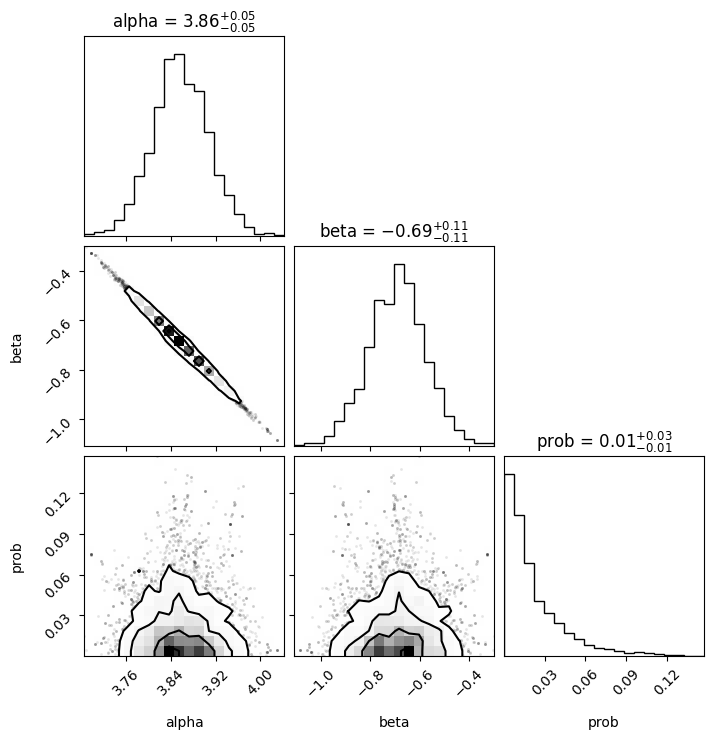

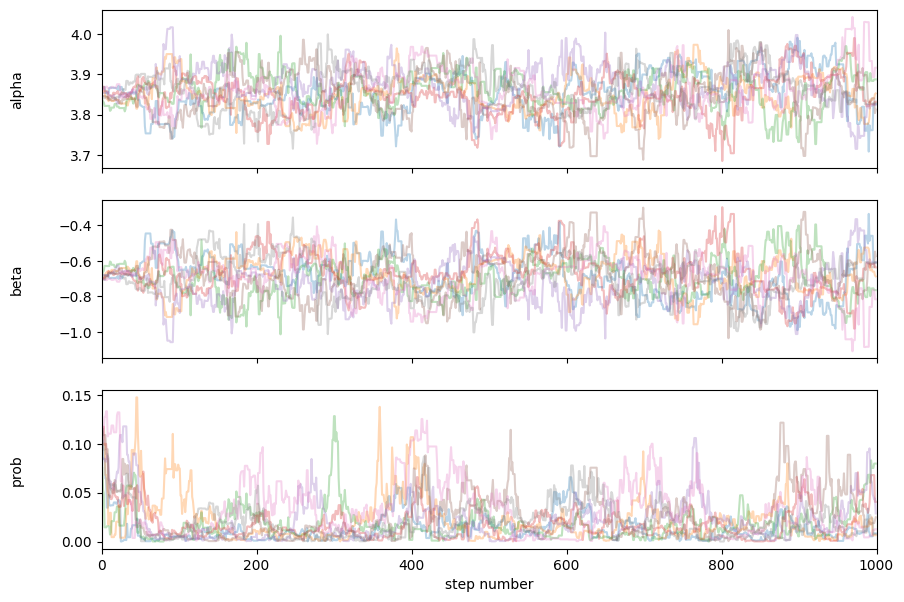

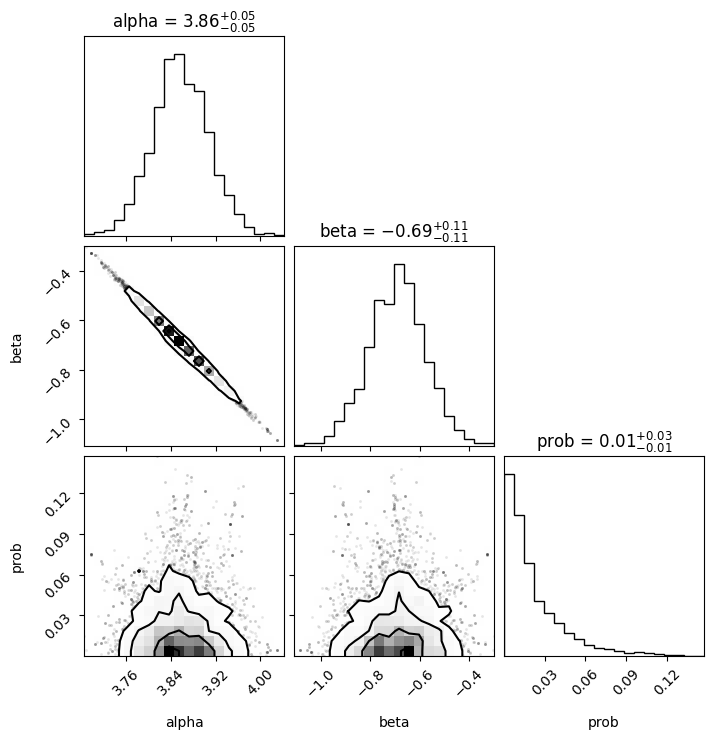

In [281]:
import emcee 
import corner 
from scipy.special import logsumexp

mu_b, V_b = 0.03, 0.01

def ln_model_likelihood(theta, y, x, y_unc, x_unc):
    m, b, out_p = theta 
    model_preds = m*x + b 
    total_unc = np.sqrt(y_unc**2 + x_unc**2)
    lnl = -0.5 * np.sum( (y - model_preds)**2/(2*(total_unc**2)) )
    return lnl

def ln_model_likelihood(theta, y_obs, x_obs, y_obs_unc, x_obs_unc): 
    theta1, theta0, out_p = theta 
    alpha = np.arctan(theta1)
    
    lnl = 0 
    for i in range(len(y_obs)):
        sigma_i = np.array([[x_obs_unc[i]**2, 0], 
                            [0, y_obs_unc[i]**2]]) 
        n = np.array([[-np.sin(alpha)], 
                      [np.cos(alpha)]
                      ])
        sigma_i_squared = (n.T @ sigma_i @ n)
        sigma_i_squared = sigma_i_squared[0][0]

        z_i = np.array([
            [x_obs[i]], 
            [y_obs[i]]
            ])        
        
        delta_i = (n.T @ z_i)[0][0] - theta0*np.cos(alpha)

        lnl += -1*(delta_i**2) / (2*sigma_i_squared)
    return lnl

def ln_outlier_likelihood(theta, y, x, y_unc, x_unc):
    m, b, out_p = theta 
    model_preds = m*x + b 
    outlier_unc = np.sqrt((y_unc**2+V_b) + (x_unc**2+V_b)) 
    lnl = - 0.5 * np.sum( (y - mu_b)**2/(2*(outlier_unc**2)) ) # compute the log likelihood  
    return lnl 

def lnlikelihood(theta, y, x, y_unc, x_unc):
    _, _, out_p = theta
    model_lnl = ln_model_likelihood(theta, y, x, y_unc, x_unc) 
    outlier_lnl = ln_outlier_likelihood(theta, y, x, y_unc, x_unc) 

    b = np.ones((2,len(x)) )
    b[0] = 1. - out_p
    b[1] = out_p
    
    # take into account both model and outlier likelihoods
    return np.sum(logsumexp(np.vstack((model_lnl, outlier_lnl)), b=b, axis=0))

# def lnlikelihood(theta, y, x, y_unc, x_unc):
#     alpha, beta, p_out = theta 
#     alpha = np.arctan(alpha)

#     lnl = 0
#     for i in range(len(y)):
#         # =======================================================
#         sigma_i = np.array([[x_unc[i]**2, 0], 
#                             [0, y_unc[i]**2]]) 
#         n = np.array([[-np.sin(alpha)], 
#                       [np.cos(alpha)]
#                       ])
#         sigma_i_squared = (n.T @ sigma_i @ n)
#         sigma_i_squared = sigma_i_squared[0][0]

#         z_i = np.array([
#             [x[i]], 
#             [y[i]]
#             ])        
        
#         delta_i = (n.T @ z_i)[0][0] - beta*np.cos(alpha)

#         # likelihood that this datapoint is from this model
#         lnl_model = -1*(delta_i**2) / (2*sigma_i_squared)
#         # ========================================================
#         # ========================================================
#         lnl_out = np.log((1 / np.sqrt(2*np.pi*(V_b + y_unc[i]**2)))) + -1*((y[i] - mu_b)**2)/(2*(V_b + y_unc[i]**2))
#         # ========================================================
#         lnl += (1-p_out)*(lnl_model) + p_out*lnl_out 
    
#     return lnl 

def lnprior(theta):
  alpha, beta, out_p = theta
  if (-10.0 < alpha < 10.0) and (-10.0 < beta < 10.0) and (0 < out_p < 1): 
      return np.log(1/20) + np.log(1/20) + np.log(1)
      # return 0
  return -np.inf
  
def lnposterior(theta, y, x, y_unc, x_unc): 
    lnp = lnprior(theta) # compute the log prior  
    if not np.isfinite(lnp): return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc, x_unc) # the log likelihood function 
    
    return lnl + lnp # return the log posterior 

p0 = (alpha, beta, 0.1)
pos = np.array(p0) + 1e-2 * np.random.randn(8, 3)  # Add a bit of random noise
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnposterior, args=(log_M_BH, log_sigma, log_M_BH_unc, log_sigma_unc)) 
sampler.run_mcmc(pos, 1000, progress=True) 

labels = ['alpha', 'beta', 'prob'] 
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=100, flat=True)  # Discard first 100 steps
corner.corner(sampler.flatchain, labels=labels, show_titles=True)

# Conclusion

In this project, we attempted to fit a line describing the relation between super massive blackholes and their dispersion speed in log space. We used frequentist and bayesian approaches for line fitting, while also accounting for uncertainties in the x-axis and y-axis. We also marginalized over outliers, and saw that outliers aren't really present in the dataset. In the end, the results didn't differ much between frequentist and bayesian approaches in this case. 